<a href="https://colab.research.google.com/github/jjablonski-it/pjatk-mhe/blob/main/MHE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zaimplementuj GA dla Twojego zadania. Jest tu sporo elementów, dlatego dopuszczam częściowe rozwiązania i każde będę oceniał indywidualnie. Niech będzie:
	
- 2 metody krzyżowania
- 2 metody mutacji
- 2 warunki zakończenia

Parametrami niech będzie - wybór metody krzyżowania, mutacji oraz warunku zakończenia. Parametrem niech będzie także liczba osobników w populacji.

## GA:
- Population
- Fitness Calculation
- Mating Pool
- Parents Selection
- Mating -> Crossover/Mutation
- Offspring

In [231]:
import random
import math
import matplotlib.pyplot as plt

In [232]:
# constants
LENGTH = 200
VALUE_RANGE = 100000

In [233]:
data = [random.randint(-VALUE_RANGE,VALUE_RANGE) for _ in range(LENGTH)]
data[0] = 0
print(0 in data)

True


In [234]:
# functions
def random_index():
  return ''.join(['%d' % random.randint(0,1) for _ in range(LENGTH)])

def index_to_set(index):
  result = []
  for i, x in enumerate(list(index)):
    if(x=='1'):
      result.append(i)
  return list(map(lambda x: data[x] ,result))

def subset_sum(index):
  return abs(sum(index_to_set(index)))

def negate_bit(index, n):
  index_list = list(index)
  bit = index_list[n]
  index_list[n] = '1' if bit=='0' else '0'
  return ''.join(index_list)

def generate_neighbours(index):
  return filter(lambda x: x != '0'*LENGTH, [negate_bit(index, x) for x in range(LENGTH)])

def get_best_index(indices):
  sum_dict = {index: subset_sum(index) for index in indices}
  return min(sum_dict, key=sum_dict.get)

def plot_indices_to_sum(indices):
    plt.plot(list(map(lambda x: subset_sum(x), indices)))

def bruteforce_lowest_sum(val=0):
  all_indices = list(map(lambda x: ("{:0"+str(LENGTH)+"b}").format(x), range(1,2**LENGTH)))
  print('generated all incides, testing...')
  best = subset_sum(all_indices[0])
  for x in all_indices:
    result = subset_sum(x)
    if(result <= val): 
      return result
    if(result < best): 
      best = result
  return best

In [240]:
class GA:
  def __init__(self, pop_size, mutation_rate):
    self.pop_size = pop_size
    self.mutation_rate = mutation_rate
    self.generation = self.create_generation()
    self.generation_count = 0
    self.best_index = get_best_index(self.generation)
    self.best_indices_per_gen = [self.best_index]
    self.average_sum_per_gen = [self.get_average_sum()]

  def next_generation(self):
    mating_pool = self.create_mating_pool()
    parent = self.select_parent(mating_pool) 
    next_generation = self.mate(parent)
    self.generation = self.create_generation(next_generation)
    self.generation_count += 1
    self.update_best_index()

  def n_next_generations(self, n):
    for _ in range(n):
      self.next_generation()
      if self.end_condition():
        break
             
  def create_generation(self, start_array=[]):
    generation = set(start_array)
    while(len(generation) < self.pop_size):
      generation.add(random_index())
    return generation

  def end_condition(self):
    condition = subset_sum(self.best_index) == 0
    if condition:
      print('found solution:', self.best_index)
    return condition

  def fitness_function(self, index):
    index_sum = subset_sum(index)
    if(index_sum==0): return ((VALUE_RANGE*LENGTH) * 2) # twice the max amount
    score = ((VALUE_RANGE*LENGTH) // index_sum)
    return score

  def create_mating_pool(self):
    index_score_dict = {index: self.fitness_function(index) for index in self.generation}
    total = sum(index_score_dict.values())
    index_prob_dict = {index: math.floor((score/total)*100) for index,score in index_score_dict.items()}
    pool_nested = [[index]*(prob) for index,prob in index_prob_dict.items()]
    return [item for sublist in pool_nested for item in sublist]

  def select_parent(self, pool):
    return random.choice(pool)

  def crossover(self, index_a, index_b):
    slice_point = random.randint(0, LENGTH-1)
    child = index_a[:slice_point] + index_b[slice_point:]
    return self.mutation(child)

  def mutation(self, index):
    rand = random.random()
    if rand < self.mutation_rate:
      mutation_point = random.randint(0, LENGTH-1)
      mutated_index = negate_bit(index, mutation_point)
      return mutated_index
    return index

  def mate(self, parent_index):
    new_generation = map(lambda index: self.mutation(self.crossover(index, parent_index)), self.generation)
    return set(new_generation)

  def update_best_index(self):
    current_best = get_best_index(self.generation)
    self.best_indices_per_gen.append(current_best)
    self.average_sum_per_gen.append(self.get_average_sum())
    if(subset_sum(current_best) < subset_sum(self.best_index)):
       self.best_index = current_best

  def get_average_sum(self):
    return sum(map(lambda index: subset_sum(index), self.generation))/len(self.generation)

  def show_status(self):
    print('generation_count', self.generation_count)
    print('average_sum', self.get_average_sum())
    print('best_sum', subset_sum(self.best_index))
    print('curr_best_sum', subset_sum(self.best_indices_per_gen[-1]))


ga = GA(100, 0.1)
ga.show_status()

generation_count 0
average_sum 440566.07
best_sum 6564
curr_best_sum 6564


found solution: 00111010010001101011001000110011111000010011100010100001001100110100100000111100110011011011111010101100110001101010111110001001010001000000001001010010000010110001101001010011011100101110000010101010
generation_count 12407
average_sum 100567.82
best_sum 0
curr_best_sum 0


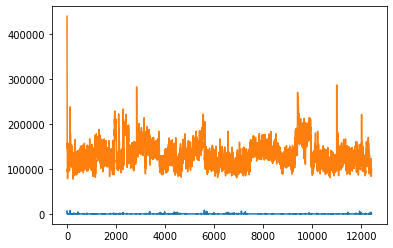

In [249]:
ga.n_next_generations(10000)
ga.show_status()
plot_indices_to_sum(ga.best_indices_per_gen)
plt.plot(ga.average_sum_per_gen)

In [250]:
ga.generation

{'00000000011101101000001000110011111000010011100010100001001100110100100000111100110011011011110010101100110001101010111110001001010001000000001001010010000010110001101001010011011100101110000010101010',
 '00000010010001101011001000110011111000010011100010100001001100110100100000111100110011011011111010101100110001101010111110001001010001000000001001010010000010110001101001010011011100101110000010101010',
 '00000101000001101011101000110010111001000011100010100101001100110100100000111100110011011011111010101100110001101010111110001001010001000000001001010010000010110001101001010011011100101110000010101010',
 '00000101001111101011101000110010111001000011100010100001001100110100100000111100110011011011111010101100110001101010111110001001010001000000001001010010000010110001101001010011011100101110000010101010',
 '0000100100000110111110100011001011100100001110001010000100110011010010000011110011001101101111101010110011000110101011111000100101000100000000100101001000001011000110100101001101

### Analiza mutation_ratio

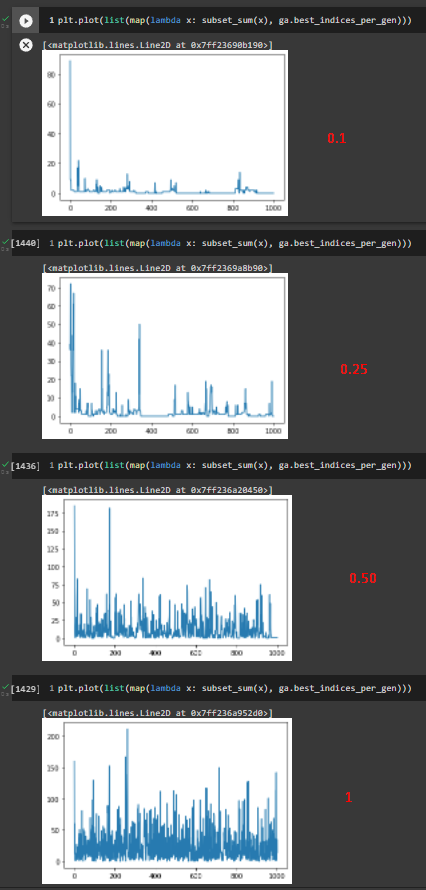